In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from scipy.spatial.distance import euclidean as euc_dist

Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

Часть открытых данных есть, например, на сайте archive.org:

https://archive.org/details/201309_foursquare_dataset_umn

Скачаем любым удобным образом архив fsq.zip с этой страницы.

Для удобной работы с этим документом преобразуем его к формату csv, удалив строки, не содержащие координат — они неинформативны для нас.

In [2]:
data = pd.read_csv('checkins.dat',sep = '|').drop(0)

c:\program files\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.columns = data.columns.str.strip()
data['latitude'] = data['latitude'].str.strip()
data['longitude'] = data['longitude'].str.strip()

In [4]:
data = data[(data['longitude'] != '')&(~data['longitude'].isna())]
data['latitude'] = data['latitude'].astype(float)
data['longitude'] = data['longitude'].astype(float)

С помощью pandas построим DataFrame и убедимся, что все 396634 строки с координатами считаны успешно.

In [5]:
data.shape

(396634, 6)

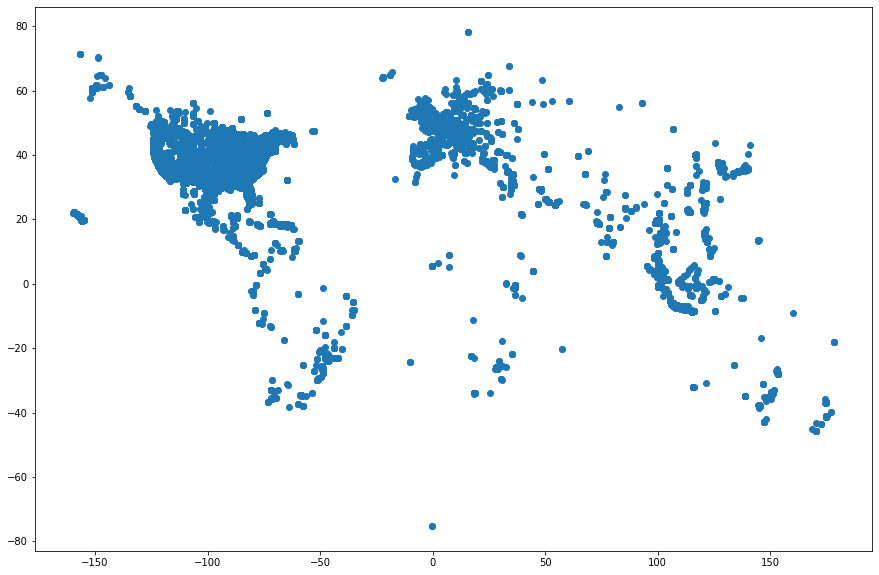

In [6]:
plt.figure(figsize=(15,10))
plt.scatter(data['longitude'],data['latitude'])

Теперь необходимо кластеризовать данные координаты, чтобы выявить центры скоплений туристов. Поскольку баннеры имеют сравнительно небольшую площадь действия, нам нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров.

Эта задача — хороший повод познакомиться с алгоритмом MeanShift, который мы обошли стороной в основной части лекций. Его описание при желании можно посмотреть в sklearn user guide, а чуть позже появится дополнительное видео с обзором этого и некоторых других алгоритмов кластеризации. Используйте MeanShift, указав bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

Примечание:на 396634 строках кластеризация будет работать долго. Быть очень терпеливым не возбраняется — результат от этого только улучшится. Но для того, чтобы сдать задание, понадобится сабсет из первых 100 тысяч строк. Это компромисс между качеством и затраченным временем. Обучение алгоритма на всём датасете занимает около часа, а на 100 тыс. строк — примерно 2 минуты, однако этого достаточно для получения корректных результатов.

Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.



In [7]:
ms = MeanShift(bandwidth=0.1)

In [8]:
train_data = data[['longitude','latitude']][:100000]

In [9]:
ms.fit(train_data)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 3230


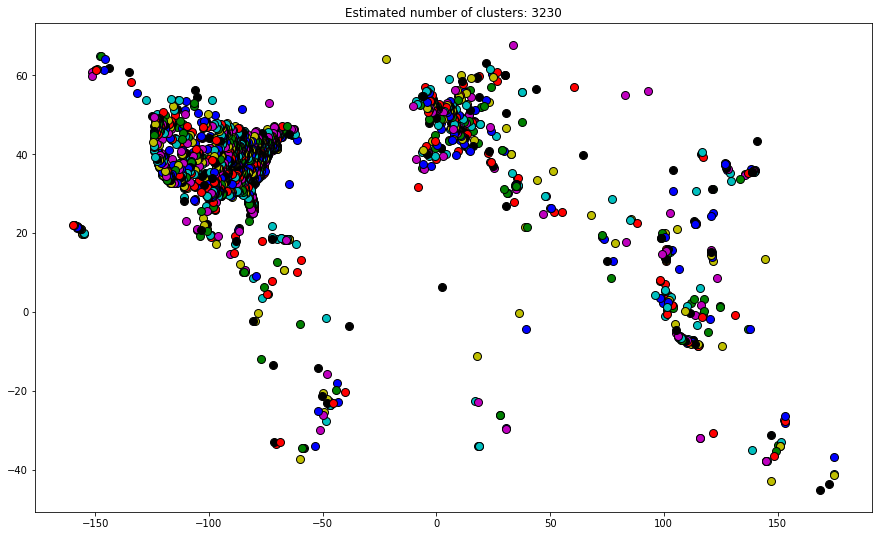

In [10]:
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(figsize=(15, 9))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
#     plt.plot(train_data[my_members, 0], train_data[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=8)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [11]:
from collections import Counter
c = Counter(labels)
cluster_counts = np.array(list(c.items()))

In [53]:
# Создаем датафрейм с номером кластера, числом чекинов, долготой и широтой
df = pd.DataFrame(np.concatenate((cluster_counts, cluster_centers), axis=1), columns=[
                  'claster', 'count', 'longitude', 'latitude'])
df.head()

,claster,count,longitude,latitude
0,5.0,2409.0,-73.991835,40.717716
1,7.0,1601.0,-112.002140,33.449438
2,30.0,594.0,-111.901888,33.446380
3,66.0,186.0,-87.629843,41.878244
4,1.0,4692.0,-122.409330,37.688682


In [13]:
df_big_clusters = df[df['count']>15]
df_big_clusters.shape

(592, 4)

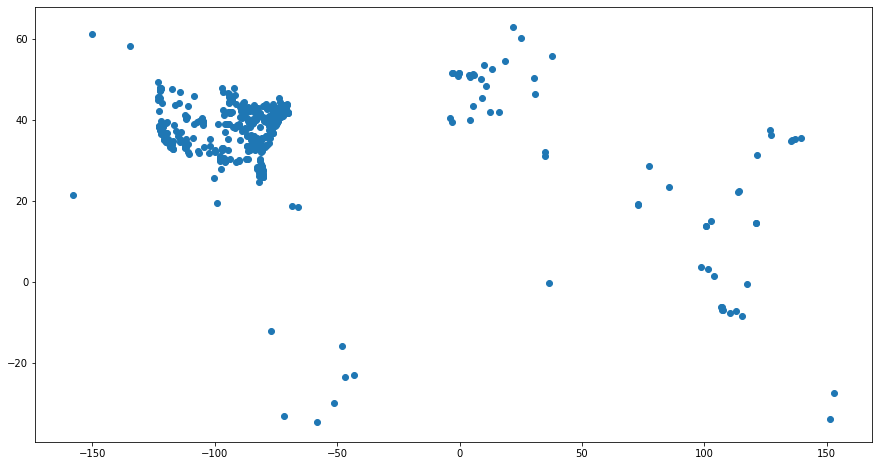

In [14]:
plt.figure(figsize=(15, 8))
plt.scatter(df_big_clusters['longitude'], df_big_clusters['latitude'])

Как мы помним, 20 баннеров надо разместить близ офисов компании. Найдем на Google Maps по запросу Carnival Cruise Line адреса всех офисов:

33.751277, -118.188740 (Los Angeles)

25.867736, -80.324116 (Miami)

51.503016, -0.075479 (London)

52.378894, 4.885084 (Amsterdam)

39.366487, 117.036146 (Beijing)

-33.868457, 151.205134 (Sydney)

Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

Примечание: при подсчете расстояний и в кластеризации можно пренебречь тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико.

Для сдачи задания выберите из получившихся 20 центров тот, который наименее удален от ближайшего к нему офиса. Ответ в этом задании — широта и долгота этого центра, записанные через пробел.


In [15]:
officies = pd.DataFrame([[-118.188740, 33.751277, 'Los Angeles'],
                         [-80.324116, 25.867736, 'Miami'],
                         [-0.075479, 51.503016,  'London'],
                         [4.885084, 52.378894, 'Amsterdam'],
                         [117.036146, 39.366487, 'Beijing'],
                         [151.205134, -33.868457, 'Sydney']],
                        columns=['longitude', 'latitude', 'city'])
officies

,longitude,latitude,city
0,-118.188740,33.751277,Los Angeles
1,-80.324116,25.867736,Miami
2,-0.075479,51.503016,London
3,4.885084,52.378894,Amsterdam
4,117.036146,39.366487,Beijing
5,151.205134,-33.868457,Sydney


In [16]:
# Создаем новый столбец в датафрейме, в который будет записываться расстояние до ближайшего офиса
df_big_clusters.loc[:, 'min_dist_to_office'] = None
for i, row in df_big_clusters.iterrows():

    dist_array = []
    # Широта и долгота цертра кластера
    loc_claster_center = np.array(
        df_big_clusters.loc[i, ['longitude', 'latitude']])
    for n, row in officies[['longitude', 'latitude']].iterrows():
        # Широта и долгота офиса
        loc_city = np.array(row[:2])
        # Расстояние между текущим кластером и офисом
        dist = euc_dist(loc_claster_center, loc_city)
        dist_array.append(dist)
    # Среди 6 расстояний до ближайшего офиса выбираем минимальное и записываем в датафрейм
    df_big_clusters.loc[i, 'min_dist_to_office'] = sorted(dist_array)[0]

c:\program files\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\program files\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
df_big_clusters.sort_values('min_dist_to_office').head(20)

,claster,count,longitude,latitude,min_dist_to_office
404,140.0,103.0,151.204776,-33.860630,0.00783476
410,118.0,106.0,-80.318891,25.845672,0.0226741
58,171.0,74.0,-0.125537,51.502991,0.0500583
29,10.0,1298.0,-80.217938,25.785812,0.134109
92,21.0,722.0,-80.199991,26.010098,0.188876
87,100.0,109.0,-118.048928,33.888325,0.195779
42,210.0,46.0,-118.362091,33.872986,0.211811
1015,1300.0,21.0,-0.365177,51.506479,0.289719
119,71.0,203.0,-118.007405,33.983936,0.294979
55,412.0,28.0,-80.158907,26.120863,0.30227


In [51]:
coordinates = list(df_big_clusters.sort_values(
    'min_dist_to_office').iloc[0, -3:-1].astype(str))
coordinates.sort()
answ = ' '.join(coordinates)
answ

'-33.86063042857143 151.20477592857145'

In [52]:
with open("answer.txt", "w") as f:
    f.write(answ)